## KalmanODE & KalmanODE_py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.Kalman.ode_init import car_init, indep_ode_init
from probDE.cython.KalmanTest.KalmanODE import KalmanODE
from probDE.utils.utils import rand_mat
from scipy.integrate import odeint

%load_ext cython

In [ ]:
from math import sin
from scipy import integrate
def ode_py(x_t, t, theta=None):
    return sin(2*t) - x_t[0]

# ode function in odeint format
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [26]:
# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .5

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

In [27]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)
# \XX_0 is drawn
x0_state = kinit[-1]

# Initialize the Kalman class
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py)
# Run the solver to get an approximation
kalman_sim = kalmanode.solve(x0_state, mv=False, sim=True)

In [28]:
# Timings for KalmanODE
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalman_cy = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

403 µs ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
# Timings for KalmanODE in pure Python
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalman_py = %timeit -o -n 100 _ = kalmanode_py.solve(x0_state, mv=False, sim=True)

# Timings for odeint
#tseq = np.linspace(tmin, tmax, n_eval+1)
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)

18.7 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.94 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
print('py/cy: {}'.format(kalman_py.average/kalman_cy.average))
print('ode/cy: {}'.format(ode.average/kalman_cy.average))

py/cy: 46.29692520154718
ode/cy: 4.807710355268037


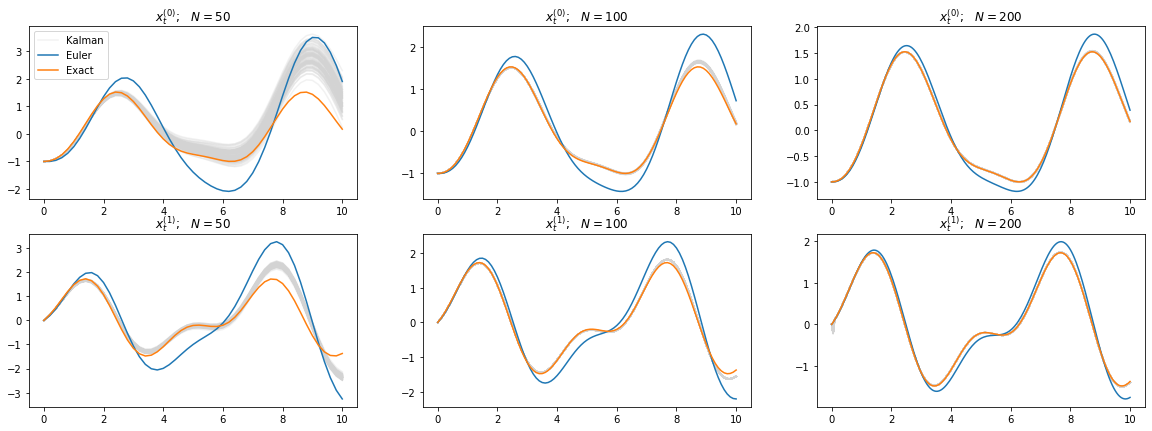

In [5]:
from probDE.Examples.readme_graph import readme_graph
draws = 100
XXn = readme_graph(ode_py, n_state, n_meas, tmin, tmax, w_vec, x0, draws)

## Lorenz63

In [6]:
def lorenz0(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 3
    x, y, z = X_t[0], X_t[1], X_t[2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

In [7]:
# RHS of ODE
def lorenz(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 2
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y])

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 6 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 2
n_var_states = np.array([n_state1, n_state2, n_state3])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 5000
tmin = 0
tmax = 20
theta=(28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

In [8]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit = indep_ode_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                        car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1]),
                        car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], x0[2])], n_state)
x0_state = kinit[-1]

# Initialize the Kalman class
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

In [ ]:
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=False, sim=True)

In [ ]:
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, theta, mv=False, sim=True)

In [ ]:
from probDE.Examples.lorenz_graph import lorenz_graph
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])
draws = 1000
lorenz_graph(lorenz, n_state, n_meas, tmin, tmax, n_eval, w_mat, n_var_states, tau, sigma, x0, theta, scale, draws)

## Lane-Emden

In [10]:
def lane(x_t, t, theta=None):
    return np.array([-2/t*x_t[1] - x_t[0]**5])

# LHS vector of ODE
w_vec = np.array([0., 0., 1.])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 200
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 10
sigma = .001

# Initial value, x0, for the IVP
x0 = np.array([1., 0., -1.]) #Initial State

In [11]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)
x0_state = kinit[-1]

# Cython
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_lane_sim = kalmanode.solve(x0_state, mv=False, sim=True)

In [ ]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

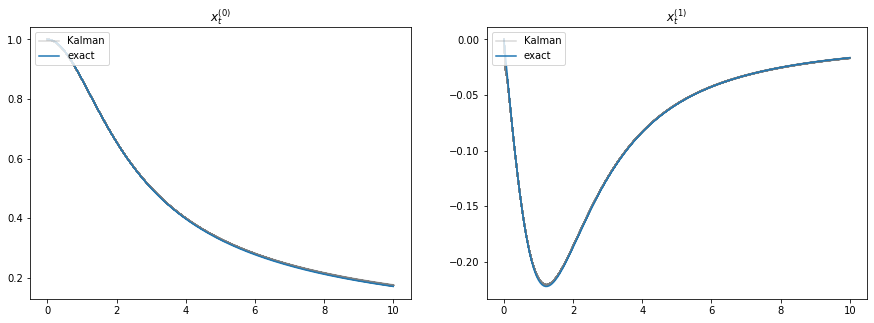

In [12]:
from probDE.Examples.lane_graph import lane_graph
draws = 100
lane_graph(lane, n_state, n_meas, tmin, tmax, n_eval, w_vec, tau, sigma, x0, draws)

## FitzHugh-Nagumo

- The ODE model is

    $$
    \frac{dV_t}{dt} = c(V_t - V_t^3/3 + R_t), \qquad \frac{d R_t}{dt} = -(V_t - a + b R_t)/c.
    $$

- The true parameter values are $a = .2$, $b = .2$, $c = 3$.

- The parameter priors are $\theta_j \stackrel{ind}{\sim} \mathrm{LogNormal}(\theta_{\star j}, 1)$, where $\theta_j \in \{a, b, c\}$ and $\theta_{\star j}$ is the corresponding true parameter value.

- Data is observed at time points $t = 1, 2, \ldots, 40$, with some error.  That is,

    $$
    y_{1n} \stackrel{ind}{\sim} \mathcal N(V_n, .01^2), \qquad y_{2n} \stackrel{ind}{\sim} \mathcal N(R_n, .01^2) 
    $$

- The step sizes for the discretization are $h = (.005, .01, .02, .05, .1)$.

In [13]:
from probDE.Examples.fitz_plot import fitz_plot
def fitz(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    V, R = X_t[0], X_t[n_state1]
    return np.array([c*(V - V**3/3 + R), -1/c*(V - a + b*R)])

In [19]:
# These parameters define the order of the ODE and the CAR(p) process
n_state1 = 3 # State dimension of V_n
n_state2 = 3 # State dimension of R_n
n_state = 6 # Total state
n_meas = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
h = 0.1 # step size
n_eval = int((tmax-tmin)/h)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, a, for the IVP
theta_true = np.array([0.2, 0.2, 3]) # True theta
x0 = [-1, 1]
v0 = [1, 1/3]
X0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# logprior parameters
n_theta = len(theta_true)
phi_sd = np.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

In [20]:
# initialize fitz_plot class and simulate date via odeint
fplot = fitz_plot(n_state1, tmin, tmax)
Y_t, X_t = fplot.simulate(x0, theta_true, gamma)

In [16]:
# Euler simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_euler = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    phi_hat, phi_var = fplot.phi_fit(fplot.euler_nlpost, Y_t, x0, hlst[i], theta_true, phi_sd, gamma)
    Theta_euler[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

In [21]:
# Kalman simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    kinit = indep_ode_init([car_init(n_state1, tau[0], sigma[0], hlst[i], w_mat[0], X0[0]),
                            car_init(n_state2, tau[1], sigma[1], hlst[i], w_mat[1], X0[1])],
                            n_state)
    x0_state = kinit[-1]
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, fitz)
    fplot.kode = kode
    phi_hat, phi_var = fplot.phi_fit(fplot.kalman_nlpost, Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma)
    Theta_kalman[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

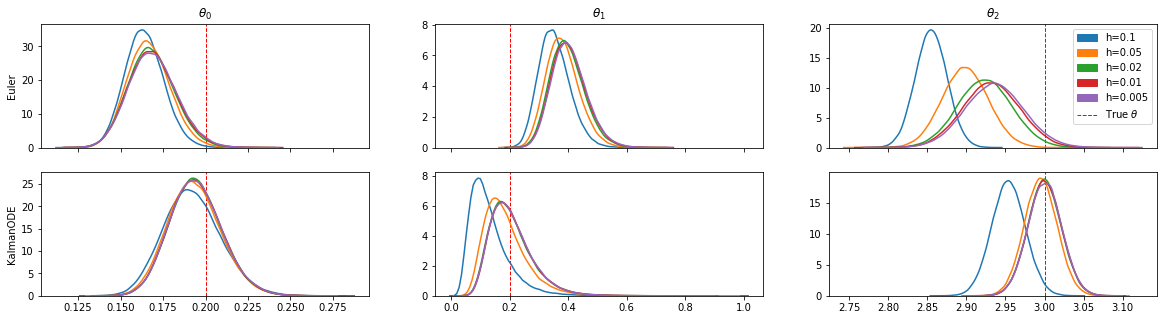

In [22]:
# Euler, Kalman plots
fplot.theta_plot(Theta_euler, Theta_kalman, theta_true, hlst)